In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### This report contains the code, and the visulization part as well as a brief commentary at the end.

In [2]:

"""
Class: Stat232C
Project 4: Signaling Policy
Name:
Date: May 14, 2020

Goal:   return the new reward function
        get a policy that reflects signaling to an observer for each possible true goal in the environment.
        visualize the policy as before by providing graphs of the value table and policy
        write a brief commentary on what has changed between the original goal policies and the new signaling policies.
"""


class GetLikelihoodReward(object):
    def __init__(self, transitionTable, goalPolicies):
        self.transitionTable = transitionTable
        self.goalPolicies  = goalPolicies #can be dictionary of form goal:goal policy or a list, but trueGoal should link to the correct policy here

    def __call__(self, trueGoal, originalReward, alpha):
        
        prob_g_s_sn=dict.fromkeys(self.goalPolicies) 
        #prob_g_s_sn={}
        
        for goal, Policy in self.goalPolicies.items():
            prob_g_s_sn[goal]={}

            ## Calculate P(s'|s, g)
            for s, asnewR in originalReward.items():
                prob_g_s_sn[goal][s]={}
                
                for a, snewR in originalReward[s].items():

                    for snew, r_orig in originalReward[s][a].items():
                        P= self.transitionTable[s][a][snew]

                        prob_g_s_sn[goal][s][snew] =  P* Policy[s][a]
         
        #print(prob_g_s_sn)       

            ## new reward function
            
        newReward = dict.fromkeys(originalReward) 
        for s, asnewR in originalReward.items():
            newReward[s] = {}
            for a, snewR in originalReward[s].items():
                newReward[s][a] ={}

                for snew, r_orig in originalReward[s][a].items():
                     
                    r_info = prob_g_s_sn[trueGoal][s][snew]/( prob_g_s_sn['A'][s][snew]+prob_g_s_sn['B'][s][snew]+prob_g_s_sn['C'][s][snew])

                    r_new=r_orig + alpha* r_info
                    
                    newReward[s][a][snew] = r_new
        

        return(newReward)
    



In [16]:
class ValueIteration(object):
    def __init__(self, transitionTable, rewardTable, convergenceTolerance, gamma):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = dict.fromkeys(transitionTable, 0)
        self.convergenceTolerance = convergenceTolerance
        self.gamma = gamma

    def __call__(self):
                
        policyTableTemp = dict.fromkeys(self.valueTable)
        
        while True:
            delta=0
            for s, oldvalue in self.valueTable.items():
                v = oldvalue
                
                maxActionIdx=[]
                maxVal=-1000
                
                
                policyTableTemp[s]={}
                
                for action, snewP in self.transitionTable[s].items():
                    temp=0
                    
                    for snew, P in self.transitionTable[s][action].items():
                        r= self.rewardTable[s][action][snew]
                        temp += P*(r + self.gamma * self.valueTable[snew])
                    
                    
                        
                        
                    if round(temp, 3)> round(maxVal, 3):
                        maxVal=temp
                        maxActionIdx=[action]
                    elif round(temp, 3) == round(maxVal, 3):    
                        maxActionIdx.append( action )
                    
                #if s==(5,3):
                    #print(maxActionIdx, maxVal)   
                                                            
                
                self.valueTable[s]= maxVal
                
                if maxVal!=0:
                    
                    for i in range(len(maxActionIdx)):
                        policyTableTemp[s][maxActionIdx[i]]= 1./len(maxActionIdx)               
                
                delta=max(delta, abs(v- self.valueTable[s]))
                
                
            if delta < self.convergenceTolerance:
                break
            
            policyTable={k: v for k, v in policyTableTemp.items() if v is not None}
            
        return ([self.valueTable, policyTable])

def Qfunction(transitionTable, rewardTable, valueTable, gamma=0.95):
    QTableTemp = dict.fromkeys(valueTable)       

    for s, v in valueTable.items():
        QTableTemp[s]={}
        
        for action, snewP in transitionTable[s].items():
            Qvalue=0
            
            for snew, P in transitionTable[s][action].items():
                Qvalue += P*(rewardTable[s][action][snew] + gamma*valueTable[snew])
            
            QTableTemp[s][action]=Qvalue
            
    QTable={k: v for k, v in QTableTemp.items() if v is not None}
            
    return QTable    

def PolicyGivenGoal(transitionTable, originalReward, valueTable, gamma, beta ):
    QTable = Qfunction(transitionTable, originalReward, valueTable, gamma)

    ## Calculate pi(a|s,g) with softmax
    piTable = dict.fromkeys(originalReward)

    for s, asnewR in originalReward.items():
        temp={}
        for action, snewR in originalReward[s].items():
            Qvalue=QTable[s][action]
            temp[action]= np.exp(beta*Qvalue)
        ##normalize piTable[s]
        factor=1.0/sum(temp.values())
        piTable[s] = {k: v*factor for k, v in temp.items() if v is not None}
    return piTable

def visualizeValueTable(gridWidth, gridHeight, goalState, trapStates, valueTable):
    gridAdjust = .5
    gridScale = 1.5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    for goal in goalState: 
        ax.add_patch(Rectangle((goal[0]-gridAdjust, goal[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))
    
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), val in valueTable.items():
        plt.text(statex-.2, statey, str(round(val, 3)))    

    plt.show()


def visualizePolicy(gridWidth, gridHeight, goalState, trapStates, policy):
    #grid height/width
    gridAdjust = .5
    gridScale = 1.5
    arrowScale = .5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    for goal in goalState:    
        ax.add_patch(Rectangle((goal[0]-gridAdjust, goal[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), actionDict in policy.items():
        for (optimalActionX, optimalActionY), actionProb in actionDict.items():
            plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    

    plt.show()
    
    
def viewDictionaryStructure(d, levels, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(levels[indent]) + ": "+ str(key))
        if isinstance(value, dict):
            viewDictionaryStructure(value, levels, indent+1)
        else:
            print('\t' * (indent+1) + str(levels[indent+1])+ ": " + str(value))


## Main function

In [4]:
# Parameters across all goals and environments
convergenceThreshold = 10e-7
gamma = .9
beta = 2
alpha = 5



"""
	Environment specifications
	gridWidth = 7
	gridHeight = 6
	allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]
	trapStates = [(3,0), (3,1), (3,3)]
	goalA = (6,1)
	goalB = (6,4)
	goalC = (1,5)
"""

transition = {(0, 0): {(1, 0): {(1, 0): 1},(0, 1): {(0, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(0, 0): 1},(0, 0): {(0, 0): 1}},(0, 1): {(1, 0): {(1, 1): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(0, 0): 1},(0, 0): {(0, 1): 1}},(0, 2): {(1, 0): {(1, 2): 1},(0, 1): {(0, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(0, 1): 1},(0, 0): {(0, 2): 1}},(0, 3): {(1, 0): {(1, 3): 1},(0, 1): {(0, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(0, 2): 1},(0, 0): {(0, 3): 1}},(0, 4): {(1, 0): {(1, 4): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(0, 3): 1},(0, 0): {(0, 4): 1}},(0, 5): {(1, 0): {(1, 5): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(0, 4): 1},(0, 0): {(0, 5): 1}},(1, 0): {(1, 0): {(2, 0): 1},(0, 1): {(1, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(1, 0): 1},(0, 0): {(1, 0): 1}},(1, 1): {(1, 0): {(2, 1): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(1, 0): 1},(0, 0): {(1, 1): 1}},(1, 2): {(1, 0): {(2, 2): 1},(0, 1): {(1, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(1, 1): 1},(0, 0): {(1, 2): 1}},(1, 3): {(1, 0): {(2, 3): 1},(0, 1): {(1, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(1, 2): 1},(0, 0): {(1, 3): 1}},(1, 4): {(1, 0): {(2, 4): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(1, 3): 1},(0, 0): {(1, 4): 1}},(1, 5): {(1, 0): {(2, 5): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(1, 4): 1},(0, 0): {(1, 5): 1}},(2, 0): {(1, 0): {(3, 0): 1},(0, 1): {(2, 1): 1},(-1, 0): {(1, 0): 1},(0, -1): {(2, 0): 1},(0, 0): {(2, 0): 1}},(2, 1): {(1, 0): {(3, 1): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 1): 1},(0, -1): {(2, 0): 1},(0, 0): {(2, 1): 1}},(2, 2): {(1, 0): {(3, 2): 1},(0, 1): {(2, 3): 1},(-1, 0): {(1, 2): 1},(0, -1): {(2, 1): 1},(0, 0): {(2, 2): 1}},(2, 3): {(1, 0): {(3, 3): 1},(0, 1): {(2, 4): 1},(-1, 0): {(1, 3): 1},(0, -1): {(2, 2): 1},(0, 0): {(2, 3): 1}},(2, 4): {(1, 0): {(3, 4): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 4): 1},(0, -1): {(2, 3): 1},(0, 0): {(2, 4): 1}},(2, 5): {(1, 0): {(3, 5): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 5): 1},(0, -1): {(2, 4): 1},(0, 0): {(2, 5): 1}},(3, 0): {(1, 0): {(4, 0): 1},(0, 1): {(3, 1): 1},(-1, 0): {(2, 0): 1},(0, -1): {(3, 0): 1},(0, 0): {(3, 0): 1}},(3, 1): {(1, 0): {(4, 1): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 1): 1},(0, -1): {(3, 0): 1},(0, 0): {(3, 1): 1}},(3, 2): {(1, 0): {(4, 2): 1},(0, 1): {(3, 3): 1},(-1, 0): {(2, 2): 1},(0, -1): {(3, 1): 1},(0, 0): {(3, 2): 1}},(3, 3): {(1, 0): {(4, 3): 1},(0, 1): {(3, 4): 1},(-1, 0): {(2, 3): 1},(0, -1): {(3, 2): 1},(0, 0): {(3, 3): 1}},(3, 4): {(1, 0): {(4, 4): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 4): 1},(0, -1): {(3, 3): 1},(0, 0): {(3, 4): 1}},(3, 5): {(1, 0): {(4, 5): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 5): 1},(0, -1): {(3, 4): 1},(0, 0): {(3, 5): 1}},(4, 0): {(1, 0): {(5, 0): 1},(0, 1): {(4, 1): 1},(-1, 0): {(3, 0): 1},(0, -1): {(4, 0): 1},(0, 0): {(4, 0): 1}},(4, 1): {(1, 0): {(5, 1): 1},(0, 1): {(4, 2): 1},(-1, 0): {(3, 1): 1},(0, -1): {(4, 0): 1},(0, 0): {(4, 1): 1}},(4, 2): {(1, 0): {(5, 2): 1},(0, 1): {(4, 3): 1},(-1, 0): {(3, 2): 1},(0, -1): {(4, 1): 1},(0, 0): {(4, 2): 1}},(4, 3): {(1, 0): {(5, 3): 1},(0, 1): {(4, 4): 1},(-1, 0): {(3, 3): 1},(0, -1): {(4, 2): 1},(0, 0): {(4, 3): 1}},(4, 4): {(1, 0): {(5, 4): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 4): 1},(0, -1): {(4, 3): 1},(0, 0): {(4, 4): 1}},(4, 5): {(1, 0): {(5, 5): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 5): 1},(0, -1): {(4, 4): 1},(0, 0): {(4, 5): 1}},(5, 0): {(1, 0): {(6, 0): 1},(0, 1): {(5, 1): 1},(-1, 0): {(4, 0): 1},(0, -1): {(5, 0): 1},(0, 0): {(5, 0): 1}},(5, 1): {(1, 0): {(6, 1): 1},(0, 1): {(5, 2): 1},(-1, 0): {(4, 1): 1},(0, -1): {(5, 0): 1},(0, 0): {(5, 1): 1}},(5, 2): {(1, 0): {(6, 2): 1},(0, 1): {(5, 3): 1},(-1, 0): {(4, 2): 1},(0, -1): {(5, 1): 1},(0, 0): {(5, 2): 1}},(5, 3): {(1, 0): {(6, 3): 1},(0, 1): {(5, 4): 1},(-1, 0): {(4, 3): 1},(0, -1): {(5, 2): 1},(0, 0): {(5, 3): 1}},(5, 4): {(1, 0): {(6, 4): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 4): 1},(0, -1): {(5, 3): 1},(0, 0): {(5, 4): 1}},(5, 5): {(1, 0): {(6, 5): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 5): 1},(0, -1): {(5, 4): 1},(0, 0): {(5, 5): 1}},(6, 0): {(1, 0): {(6, 0): 1},(0, 1): {(6, 1): 1},(-1, 0): {(5, 0): 1},(0, -1): {(6, 0): 1},(0, 0): {(6, 0): 1}},(6, 1): {(1, 0): {(6, 1): 1},(0, 1): {(6, 2): 1},(-1, 0): {(5, 1): 1},(0, -1): {(6, 0): 1},(0, 0): {(6, 1): 1}},(6, 2): {(1, 0): {(6, 2): 1},(0, 1): {(6, 3): 1},(-1, 0): {(5, 2): 1},(0, -1): {(6, 1): 1},(0, 0): {(6, 2): 1}},(6, 3): {(1, 0): {(6, 3): 1},(0, 1): {(6, 4): 1},(-1, 0): {(5, 3): 1},(0, -1): {(6, 2): 1},(0, 0): {(6, 3): 1}},(6, 4): {(1, 0): {(6, 4): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 4): 1},(0, -1): {(6, 3): 1},(0, 0): {(6, 4): 1}},(6, 5): {(1, 0): {(6, 5): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 5): 1},(0, -1): {(6, 4): 1},(0, 0): {(6, 5): 1}}}
rewardForGoalA = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(1, 4): -1},(0, 0): {(1, 5): -0.1}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): 9},(0, 1): {(6, 2): 9},(-1, 0): {(5, 1): 9},(0, -1): {(6, 0): 9},(0, 0): {(6, 1): 9.9}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 4): -1},(0, -1): {(6, 3): -1},(0, 0): {(6, 4): -0.1}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}
rewardForGoalB = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(1, 4): -1},(0, 0): {(1, 5): -0.1}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1},(-1, 0): {(5, 1): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 1): -0.1}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): 9},(0, 1): {(6, 5): 9},(-1, 0): {(5, 4): 9},(0, -1): {(6, 3): 9},(0, 0): {(6, 4): 9.9}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}
rewardForGoalC = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): 9},(0, 1): {(1, 5): 9},(-1, 0): {(0, 5): 9},(0, -1): {(1, 4): 9},(0, 0): {(1, 5): 9.9}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1},(-1, 0): {(5, 1): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 1): -0.1}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 4): -1},(0, -1): {(6, 3): -1},(0, 0): {(6, 4): -0.1}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}


In [5]:
#GetLikelihoodReward(transition, ['A',rewardForGoalA])

In [6]:
goalStates = [(6, 1), (1, 5), (6, 4)]
gridWidth = 7
gridHeight = 6
trapStates = [(3,0), (3,1), (3,3)]
goalA = [(6,1)]
goalB = [(6,4)]
goalC = [(1,5)]
goalStates = [(6, 1), (1, 5), (6, 4)]

performValueIterationA = ValueIteration(transition, rewardForGoalA, convergenceThreshold, gamma)
optimalValuesA, originalPolicyA = performValueIterationA()
policyTableA = PolicyGivenGoal(transition, rewardForGoalA, optimalValuesA, gamma, beta)


performValueIterationB = ValueIteration(transition, rewardForGoalB, convergenceThreshold, gamma)
optimalValuesB, originalPolicyB = performValueIterationB()
policyTableB = PolicyGivenGoal(transition, rewardForGoalB, optimalValuesB, gamma,beta )



performValueIterationC = ValueIteration(transition, rewardForGoalC,  convergenceThreshold, gamma)
optimalValuesC, originalPolicyC = performValueIterationC()
policyTableC = PolicyGivenGoal(transition, rewardForGoalC, optimalValuesC, gamma, beta)

############## get new reward function
goalPolicies ={'A': policyTableA, 'B':policyTableB, 'C':policyTableC }

performLikelihoodReward=GetLikelihoodReward(transition, goalPolicies )
newReward_A=performLikelihoodReward('A', rewardForGoalA, alpha)

newReward_B=performLikelihoodReward('B', rewardForGoalB, alpha)

newReward_C=performLikelihoodReward('C', rewardForGoalC, alpha)

############# get new policy 

performValueIterationA = ValueIteration(transition, newReward_A, convergenceThreshold, gamma)
newValuesA, newPolicyA = performValueIterationA()


performValueIterationB = ValueIteration(transition, newReward_B, convergenceThreshold, gamma)
newValuesB, newPolicyB = performValueIterationB()

performValueIterationC = ValueIteration(transition, newReward_C, convergenceThreshold, gamma)
newValuesC, newPolicyC = performValueIterationC()




### Value Table and the Policy table of the original goal policy for goal A

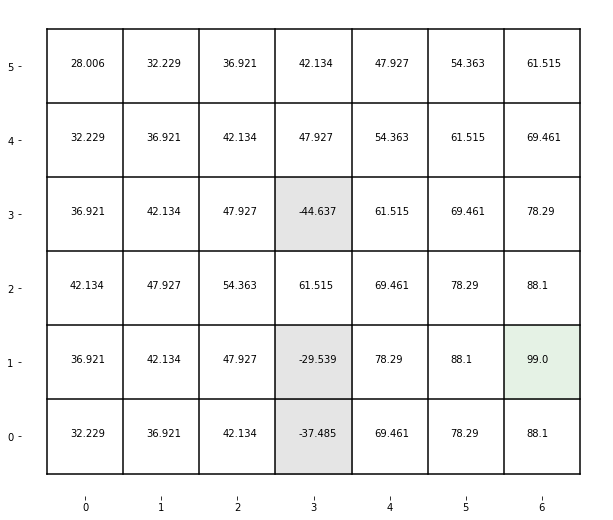

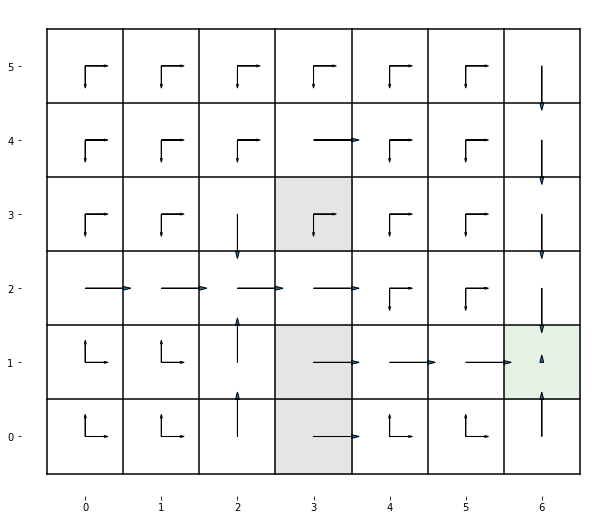

In [7]:
visualizeValueTable(gridWidth, gridHeight, goalA, trapStates,  valueTable=optimalValuesA)
visualizePolicy(gridWidth, gridHeight, goalA, trapStates, policy=originalPolicyA)


### Value Table and the Policy table that reflect signaling to an observer for goal A 


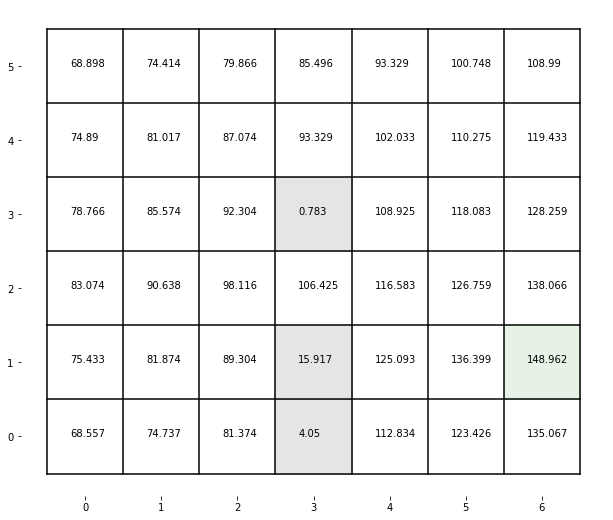

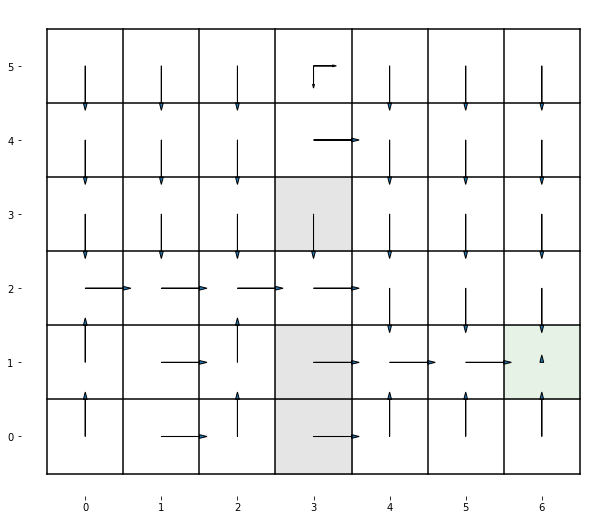

In [8]:
visualizeValueTable(gridWidth, gridHeight, goalA, trapStates,  valueTable=newValuesA)
visualizePolicy(gridWidth, gridHeight, goalA, trapStates, policy=newPolicyA)

### Value Table and the Policy table of the original goal policy for goal B

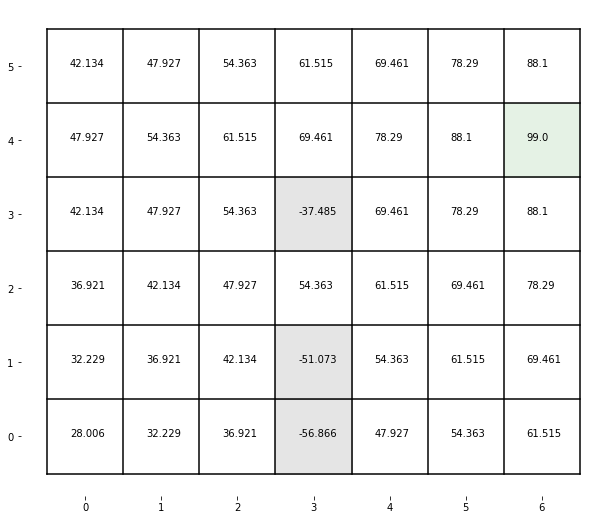

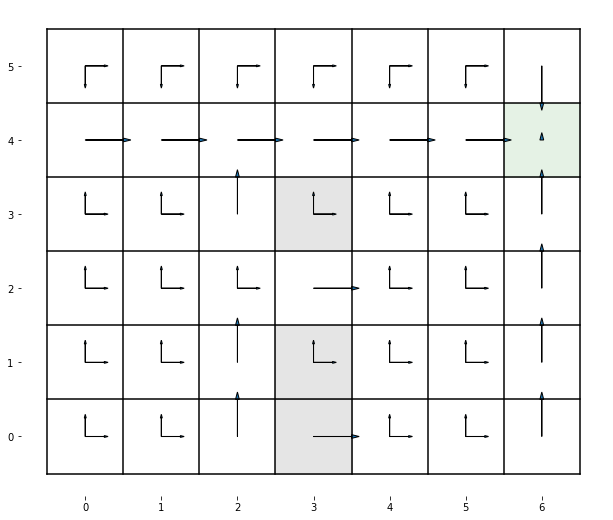

In [9]:
visualizeValueTable(gridWidth, gridHeight, goalB, trapStates,  valueTable=optimalValuesB)
visualizePolicy(gridWidth, gridHeight, goalB, trapStates, policy=originalPolicyB)


### Value Table and the Policy table that reflect signaling to an observer for goal B 


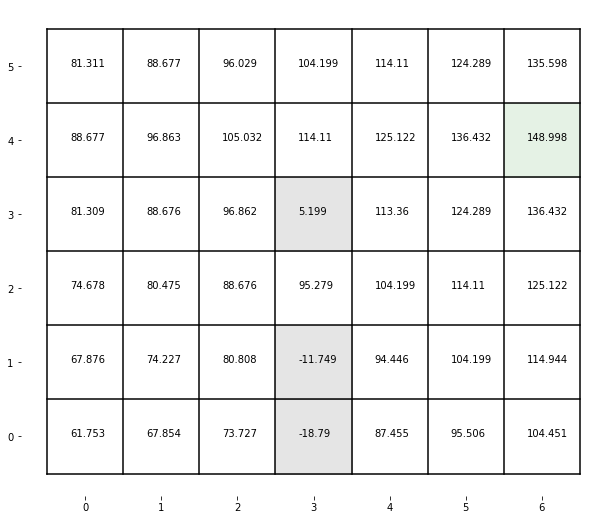

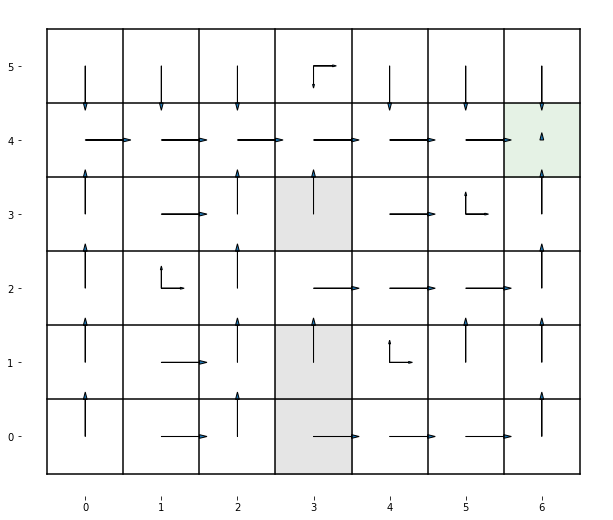

In [10]:
visualizeValueTable(gridWidth, gridHeight, goalB, trapStates,  valueTable=newValuesB)
visualizePolicy(gridWidth, gridHeight, goalB, trapStates, policy=newPolicyB)

### Value Table and Policy table of the original goal policy for goal C

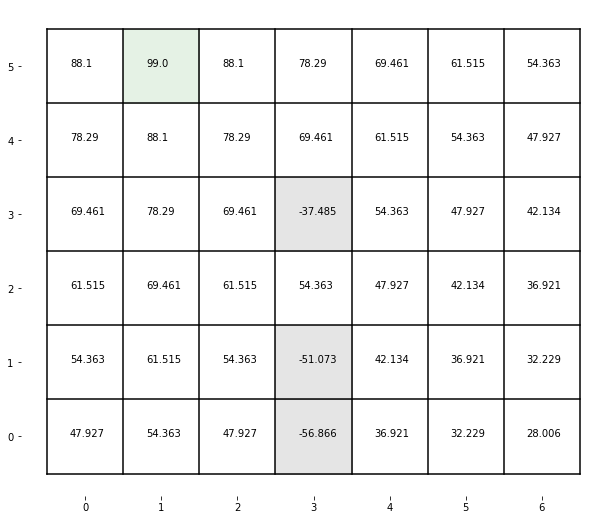

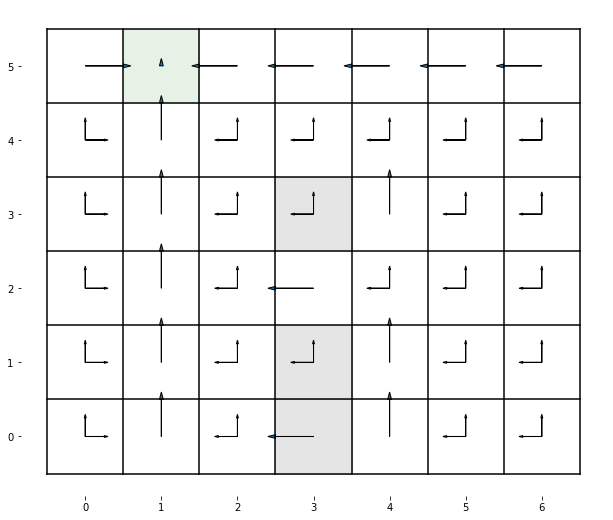

In [11]:
visualizeValueTable(gridWidth, gridHeight, goalC, trapStates,  valueTable=optimalValuesC)
visualizePolicy(gridWidth, gridHeight, goalC, trapStates, policy=originalPolicyC )


### Value Table and the Policy table that reflect signaling to an observer for goal C

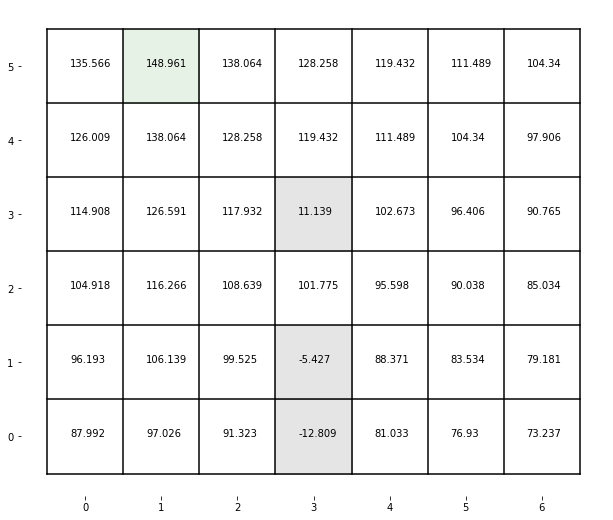

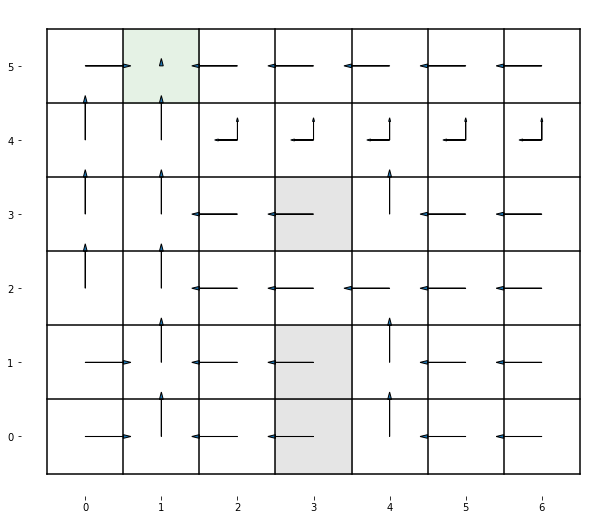

In [12]:
visualizeValueTable(gridWidth, gridHeight, goalC, trapStates,  valueTable=newValuesC)
visualizePolicy(gridWidth, gridHeight, goalC, trapStates, policy=newPolicyC)

## Write a brief commentary on what has changed between the original goal policies and the new signaling policies.


The new policy reflects signaling to an observer for the true goal in the environment. In the original policy, there are many states that have indifferent choices between two actions. But in the new policy that reflects signaling to an observer, there are much less states that have two optimal actions. This is because that in the new policy, we also consider signaling the observer of our intention while we are moving. Hence, if one action helps more in eliminating ambiguity in signaling to an observer, then that action will be selected as optimal. 